In [1]:
%tensorflow_version 1.14.0


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Extracting ./JPG-PNG-to-MNIST-NN-Format-master/train-images-idx3-ubyte.gz
Extracting ./JPG-PNG-to-MNIST-NN-Format-master/train-labels-idx1-ubyte.gz
Extracting ./JPG-PNG-to-MNIST-NN-Format-master/t10k-images-idx3-ubyte.gz
Extracting ./JPG-PNG-to-MNIST-NN-Format-master/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfxz66mde', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.pytho

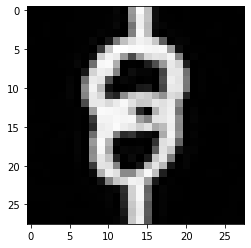

Model prediction: amp_vert


In [3]:
from __future__ import division, print_function, absolute_import
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./JPG-PNG-to-MNIST-NN-Format-master/', one_hot=False)


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 16

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 19 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

# Build the Estimator
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

# Predict single images
n_images = 100
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

class_names =['amp_horz', 'amp_vert', 'batt_horz_neg', 'batt_horz_pos', 'batt_vert_neg', 'batt_vert_pos', 'cap_horz', 'cap_vert', 'led_horz_neg', 'led_horz_pos', 'led_vert_neg' ,'led_vert_pos', 'res_horz', 'res_vert', 'trans_horz_pos', 'trans_vert_neg', 'trans_vert_pos', 'volt_horz', 'volt_vert']

# Display
for i in range(n_images):
    if preds[i] == 1:
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
        plt.show()
        print("Model prediction:", class_names[preds[i]])

In [4]:
def classify(img):
    import cv2
    
    resized_img = cv2.resize(img,(28, 28))

    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)        
    
#     inverted_img = resized_img
    
    inverted_img = cv2.bitwise_not(gray_img)
    
#     equ = cv2.equalizeHist(inverted_img)
    
    final_img = inverted_img
    
    rows,cols = final_img.shape
    x=[]

    for i in range(rows):
        for j in range(cols):
            x.append(final_img[i,j])
    
#     cv2.imshow('final_img', final_img)
    
    return get_class(x)

    
def get_class(x):
    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': np.array([np.asarray(x, dtype=np.float32)])}, shuffle=False) # x is normal array or list of pixel values
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    
    return class_names[preds[0]] 
    
    # k = cv2.waitKey(0) & 0xFF
    # cv2.destroyAllWindows()

In [9]:
from google.colab.patches import cv2_imshow

def remove_duplicates(__p):
    # remove duplicates from __p 
    # https://stackoverflow.com/questions/21065347/remove-duplicates-in-two-dimensional-array-while-maintaining-sequence
    
    print("Number of contours:(removing duplicates)  ", len(__p))
    
    seen = set()
    newlist = []
    for item in __p:
        t = tuple(item[:4])        
        if t not in seen:
            newlist.append(item)
            seen.add(t)            
    
    for item in __p:
        t = tuple(item[:4])
        if t not in seen:
            print(t)
    
    print("Number of contours:(removed duplicates) ", len(seen))
    
    return newlist

def remove_giant_boxes(seen, width, height):
    # destroy giant boxes        
#     width_list = [] 

#     for p in seen:
#         width_list.append(p[2])

#     median_width = median(width_list)
#     print("Median width: ", median_width)

#     height_list = [] 

#     for p in seen:
#         height_list.append(p[3])

#     median_height = median(height_list)
#     print("Median height: ", median_height)
    
    giants_removed=[]

    for p in seen:
        if p[2] < width/3 and p[3] < height/3:
            giants_removed.append(p)
            
    return giants_removed


def classify_circuit(filename):
    import cv2
    import numpy as np
    from math import sqrt
    from statistics import median
    import os

    name = filename

    # Width of image you want to work with
    W = 500.
    # get original image
    oriimg =cv2.imread('./'+name,1)
    
    height, width, depth = oriimg.shape
    # rescale to W width
    imgScale = W/width
    newX,newY = oriimg.shape[1]*imgScale, oriimg.shape[0]*imgScale
    img = cv2.resize(oriimg,(int(newX),int(newY)))
    test = cv2.resize(oriimg,(int(newX),int(newY)))
    # cv2.imshow('img', test)
    H, W, depth = img.shape
    print("Height: %d", H)

    img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # lower mask (0-10)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,0,0])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1

    # #erode and dialate https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # set my output img to zero everywhere except my mask
    output_img = img.copy()
    output_img[np.where(mask==0)] = 0

    # or your HSV image, which I *believe* is what you want
    output_hsv = img_hsv.copy()
    output_hsv[np.where(mask==0)] = 0

    # # Bitwise-AND mask and cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),5)original image
    res = cv2.bitwise_and(img,img, mask= mask)

    # # contour around mask
    contours, heirarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cont_sorted contains the contours    
    cont_sorted = sorted(contours, key=cv2.contourArea, reverse=True)[:]

    print(len(cont_sorted))    


    _p=[]
    org = []
    #threshhold is 10 pixels for a 500 pixel wide image. scale accordingly
    width_thresh=W/25
    height_thresh=W/25

    # iterate through the contours
    for idx, c in enumerate(cont_sorted):
    #     get the bounding boxes
        x, y, w, h = cv2.boundingRect(c)
    #     only consider bounding boxes larger than thresh
        if(w > width_thresh or h > height_thresh):                
            _p.append([x,y,w,h])
        #   _p now contains the bounding boxes of large contours
            cv2.rectangle(res,(x, y),(x+w,y+h),(0,255,0),1)

    org = _p

    helpful = 1

    while helpful == 1:
        helpful = 0
        print("Number of contours: ", len(_p))

        # __p will contain the bounding boxes of merged contours i.e. one box per schematic symbol
        __p=[]

        # iterate through each bounding box
        for idx1, p1 in enumerate(_p):
            done =0
        #     check all other bounding boxes for a box that's close to our box
            for idx2, p2 in enumerate(_p):
                x1 = p1[0]
                x2 = p2[0]
                y1 = p1[1]
                y2 = p2[1]
                w1 = p1[2]
                w2 = p2[2]
                h1 = p1[3]
                h2 = p2[3]
        #         if the bounding boxes are close together, merge them into one and put in __p
        #      multiplier should be 1.3 or more
                if idx1 != idx2:
                        close = 0
                        # if boxes are on same horizontal line
                        if abs((y1+h1/2)-(y2+h2/2)) < height_thresh:
                             if  (x1 < x2 and (abs(x2-(x1 + w1)) < max(w1, w2)/3)) or \
                                 (x2 < x1 and (abs(x1-(x2 + w2)) < max(w1, w2)/3)):
                                close = 1
                        # if boxes are on same vertical line
                        if abs((x1+w1/2)-(x2+w2/2)) < width_thresh:
                             if  (y1 < y2 and (abs(y2-(y1 + h1)) < max(h1, h2)/3)) or \
                                 (y2 < y1 and (abs(y1-(y2 + h2)) < max(h1, h2)/3)):
                                close = 1
                        
                        if close == 1:
                            __p.append([
                                int(min(x1, x2)),
                                int(min(y1, y2)),
                                int((max(x1+w1, x2+w2)-min(x1, x2))),
                                int((max(y1+h1, y2+h2)-min(y1, y2)))                
                            ])
                            done =1
                            helpful = 1
        #       didn't find a bounding box close to ours, so just add it to the __p list
            if done == 0:
                __p.append(p1)

        for p in __p:
            x = p[0]
            y=p[1]
            w=p[2]
            h=p[3]
            cv2.rectangle(res,(x, y),(x+w,y+h),(0,255,0),1)

        print("Reduced num boxes")
        print("Number of contours: ", len(__p))
        seen = remove_duplicates(__p)
        print("Removed Duplicates")
        print("Number of contours: ", len(seen))   
        giants_removed = remove_giant_boxes(seen, W, H)
        print("Removed giant boxes")
        print("Number of contours: ", len(giants_removed))   
        _p = giants_removed

    print("Number of contours: ", len(_p))        

    # iterate through all the bounding boxes for schematic symbols
    for idx, p in enumerate(_p):
        x = p[0]
        y = p[1]
        w = p[2]
        h = p[3]

        H = max(w, h)
        W = H

        x_center = x+w/2
        y_center = y+h/2

        X = int(x_center - W/2)
        Y = int(y_center - H/2)

        roi_alpha = 0

        roi = img[int(Y-H*roi_alpha):int(Y+(1+roi_alpha)*H), int(X-W*roi_alpha):int(X+(1+roi_alpha)*W)]
      
        symbol_class = classify(roi)
        
        print(symbol_class)
        
        symbol =cv2.imread('./symbols/'+symbol_class+'.png',1)

        resized_symbol = cv2.resize(symbol,(H*(1+2*roi_alpha),W*(1+2*roi_alpha)))
        
#         cv2.imshow('roi', np.hstack((roi ,resized_symbol)))
        
        img[int(Y-H*roi_alpha):int(Y+(1+roi_alpha)*H), int(X-W*roi_alpha):int(X+(1+roi_alpha)*W)] = resized_symbol
        
#         background = cv2.imread('road.jpg')
#         overlay = cv2.imread('traffic sign.png')

#         rows,cols,channels = overlay.shape

#         overlay=cv2.addWeighted(background[250:250+rows, 0:0+cols],0.5,overlay,0.5,0)

#         background[250:250+rows, 0:0+cols ] = overlay        

#         k = cv2.waitKey(0) & 0xFF
#         cv2.destroyAllWindows()

        cv2.rectangle(img,(X, Y),(X+W,Y+H),(0,255,0),1)    

#     cv2.imshow('mask',mask)
    # cv2_imshow('img',np.hstack((test, img)))
#     cv2.imshow('res',res)
    cv2_imshow(img)
    k = cv2.waitKey(0) & 0xFF

    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()

Height: %d 312
4
Number of contours:  4
Reduced num boxes
Number of contours:  4
Number of contours:(removing duplicates)   4
Number of contours:(removed duplicates)  3
Removed Duplicates
Number of contours:  3
Removed giant boxes
Number of contours:  3
Number of contours:  3
Reduced num boxes
Number of contours:  3
Number of contours:(removing duplicates)   3
Number of contours:(removed duplicates)  3
Removed Duplicates
Number of contours:  3
Removed giant boxes
Number of contours:  3
Number of contours:  3
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfxz66mde/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
led_horz_pos
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfxz66mde/model.ckpt-1000
INFO:tensorflow:Runn

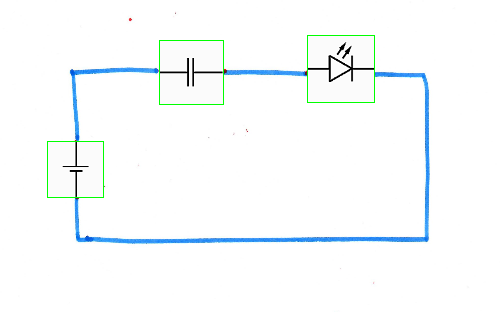

In [18]:
classify_circuit("scanned_circuit_1.jpg")